# Overview
The task is to identify sleep patterns given samples of accelerometer data. 

In [1]:
# Render our plots inline
%matplotlib inline

import numpy as np
import h5py
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame
import itertools
import math

In [2]:
def load_data(filename):
    path = 'D:/path/'+ filename
    hf = h5py.File(path, 'r')

    reread = pd.read_hdf(path)
    data = reread#.head(10000)
    hf.close()
    return data

def load_csv(filename):
    data = pd.read_csv('D:/path/'+ filename)
    
    return data

def load_targets(subject_number):
    filename = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_targets.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    targets = reread#.head(10000)
    hf.close()
    return targets

def load_features(subject_number):
    filename = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_features.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    features = reread#.head(10000)
    hf.close()
    return features

In [3]:
def combine_data(subject_ids):
    
    data = []
    y = []
    
    
    for i in range(len(subject_ids)):
        
        features = load_features(subject_ids[i])
        targets = load_targets(subject_ids[i])
        
        data.append(features)
        y.append(targets)
    
    result_X = pd.concat(data)
    result_X = result_X.reset_index()
    result_X = result_X.drop(['index'], axis = 1)
    
    result_y = pd.concat(y)
    result_y = result_y.reset_index()
    result_y = result_y.drop(['index'], axis = 1)
    
    return result_X, result_y.values.ravel()

In [4]:
#X_train = load_data('X_train_comv_xgb_5.h5')

#y_train = load_data('y_train_comv_xgb_5.h5').values.ravel()

In [5]:
# subject_ids = [1,6,14,15,18,19,20,23,24,25,27,28,29,30,31,32,35,37,39]

train_ids =[1, 6, 15, 19, 20, 23, 24, 25, 27, 28, 29, 30, 31, 32, 35, 37, 39]

test_ids = [14, 18]


X_train, y_train = combine_data(train_ids)
X_test, y_test = combine_data(test_ids)


In [6]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000760,16.435297,0.011247,0.967625,-0.963184,0.092602,52.068081,5.857407,-30340.288484,-0.096142,...,0.052196,303.454584,13.130905,44404.262312,0.037027,0.010810,0.0,318.0,2868.0,2955.0
1,0.000699,15.028792,0.009982,0.972671,-0.968978,0.084678,74.191844,7.449146,-30522.816599,-0.087389,...,0.047561,388.921686,15.019331,44394.534233,0.033747,0.010085,0.0,319.0,2923.0,2939.0
2,0.000696,15.023195,0.009897,0.972959,-0.969270,0.084646,74.408999,7.467049,-30531.990629,-0.087330,...,0.047384,394.713073,15.175882,44391.379512,0.033624,0.009810,0.0,351.0,2956.0,2894.0
3,0.000688,15.045285,0.009758,0.974033,-0.970337,0.084771,74.331662,7.471182,-30565.614155,-0.087362,...,0.047527,389.949249,15.052973,44394.278932,0.033723,0.009492,0.0,311.0,3032.0,2868.0
4,0.000676,15.014860,0.009336,0.975148,-0.971471,0.084599,75.353315,7.551253,-30601.349842,-0.087084,...,0.047408,393.861612,15.163419,44394.595935,0.033638,0.008977,0.0,285.0,3066.0,2908.0


# Model building and evaluation

In [7]:
import sklearn.metrics as met
import seaborn as sn
    
# helper function to quickly build different models
def model_build(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(array):
    array = array
    x_labels = ['sleep', 'wake']
    y_labels = ['sleep', 'wake']
    df_cm = pd.DataFrame(array, y_labels,x_labels)
    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')# font size
    plt.show()

# helper function to handle evaluation
def model_eval(pred, y_test):
    #pred = model.predict(X_test)
    print('Accuracy:\n-----------------------------')
    print(met.accuracy_score(y_test, pred))
    print('\nConfusion Matrix:\n-----------------------------')
    conf = met.confusion_matrix(y_test, pred)
    plot_confusion_matrix(conf)
    print('\nClassification Report:\n-----------------------------')
    print(met.classification_report(y_test, pred, digits= 5))
    
    TP = conf.tolist()[0][0]
    FN = conf.tolist()[0][1]
    FP = conf.tolist()[1][0]
    TN = conf.tolist()[1][1]
    sen = TP/(TP+FN)
    spe = TN/(TN+FP)
    gmean= math.sqrt(sen*spe)
    
    print('TP, FN, FP, TN: '+ str(TN)+', '+ str(FP)+', '+str(FN)+', '+str(TP))
    print('Sensitivity:' + str(sen))
    print('Specificity:' + str(spe))
    print('G-mean:'+ str(gmean))

In [8]:

#Supervised Multiview method
def multiview(X_train, y_train, X_test, y_test, classifier):
    
    #Get the predictions
    preds = get_predictions(X_train, X_test, y_train, classifier)
    
    if len(preds)==0:
        print('No classifier called '+ classifier +'. Classifier has to be "rf", "xgb", "dt" or "all".')
    else:
        labels = []
        
        #Uses a majority voting scheme to decide on the final predictions for the training data.
        for i in range(len(y_test)):
            s_count = 0
            w_count = 0

            for p in preds:
                if p[i] == 1:
                    s_count = s_count + 1
                else:
                    w_count = w_count + 1

            if s_count>w_count:
                labels.append(1)
            else:
                labels.append(2)
        
        #Print the evaluation results
        model_eval(labels, y_test)


#Function that trains the specified type of classifiers on three different views and uses them to make prediction on the
# training data.
def get_predictions(X_train, X_test, y_train, classifier):
    
    #get views for back and thigh
    #X_train_b, X_train_t, X_test_b, X_test_t = get_views(X_train, X_test)
    
    X_train_b, X_test_b = get_back_view(X_train, X_test)
    X_train_t, X_test_t = get_thigh_view(X_train, X_test)
    
    models = []
    if classifier == 'rf' or classifier == 'all':
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train, y_train))
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train_b, y_train))
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train_t, y_train))
    if classifier == 'xgb' or classifier == 'all':
        models.append(model_build(XGBClassifier(n_estimators=150), X_train, y_train))
        models.append(model_build(XGBClassifier(n_estimators=150), X_train_b, y_train))
        models.append(model_build(XGBClassifier(n_estimators=150), X_train_t, y_train))
    if classifier == 'dt' or classifier == 'all':
        models.append(model_build(DecisionTreeClassifier(), X_train, y_train))
        models.append(model_build(DecisionTreeClassifier(), X_train_b, y_train))
        models.append(model_build(DecisionTreeClassifier(), X_train_t, y_train))
    
    preds = []
    index = 0
    for i in range(int(len(models)/3.0)):
        preds.append(models[index].predict(X_test))
        preds.append(models[index+1].predict(X_test_b))
        preds.append(models[index+2].predict(X_test_t))
        index = index + 3
    
    return preds
    
#Function for getting the back view feature set
def get_back_view(X_train, X_test):
    num_features = (len(X_train.columns)-2)/7
    b_limit = int(num_features*3)+1
    
    X_train_b = X_train.iloc[:, :b_limit].copy()
    X_test_b = X_test.iloc[:, :b_limit].copy()

    return X_train_b.values, X_test_b.values

#Function for getting the thigh view feature set
def get_thigh_view(X_train, X_test):
    num_features = (len(X_train.columns)-2)/7
    b_limit = int(num_features*3)+1
    t_limit = int(num_features*6)+2
    
    X_train_t = X_train.iloc[:, b_limit:t_limit].copy()
    X_test_t = X_test.iloc[:, b_limit:t_limit].copy()
    
    return X_train_t.values, X_test_t.values


# Training and results

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy:
-----------------------------
0.8645054031587698

Confusion Matrix:
-----------------------------


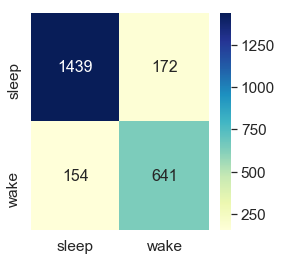


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90333   0.89323   0.89825      1611
          2    0.78844   0.80629   0.79726       795

avg / total    0.86536   0.86451   0.86488      2406

TP, FN, FP, TN: 641, 154, 172, 1439
Sensitivity:0.8932340161390441
Specificity:0.8062893081761007
G-mean:0.8486489479826802


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import time

multiview(X_train, y_train, X_test, y_test, 'dt')


Accuracy:
-----------------------------
0.9168744804655029

Confusion Matrix:
-----------------------------


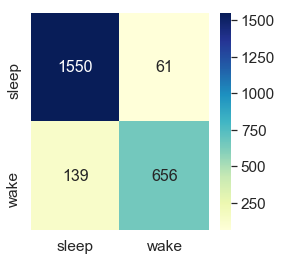


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.91770   0.96214   0.93939      1611
          2    0.91492   0.82516   0.86772       795

avg / total    0.91678   0.91687   0.91571      2406

TP, FN, FP, TN: 656, 139, 61, 1550
Sensitivity:0.9621353196772191
Specificity:0.8251572327044026
G-mean:0.8910179110837334


In [10]:
multiview(X_train, y_train, X_test, y_test, 'rf')

Accuracy:
-----------------------------
0.9334995843724023

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


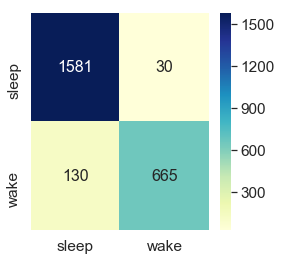


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.92402   0.98138   0.95184      1611
          2    0.95683   0.83648   0.89262       795

avg / total    0.93486   0.93350   0.93227      2406

TP, FN, FP, TN: 665, 130, 30, 1581
Sensitivity:0.9813780260707635
Specificity:0.8364779874213837
G-mean:0.9060359353509343


In [11]:
multiview(X_train, y_train, X_test, y_test, 'xgb')

Accuracy:
-----------------------------
0.9326683291770573

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


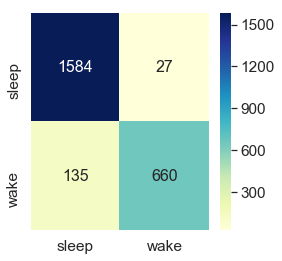


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.92147   0.98324   0.95135      1611
          2    0.96070   0.83019   0.89069       795

avg / total    0.93443   0.93267   0.93131      2406

TP, FN, FP, TN: 660, 135, 27, 1584
Sensitivity:0.9832402234636871
Specificity:0.8301886792452831
G-mean:0.90347933152793


In [12]:
multiview(X_train, y_train, X_test, y_test, 'all')